# Visualizing COVID Hospitalizations and Fatalities based on Vaccination Rate

The purpose of this project is two fold:
1. Predict the hospitalizations and fatalities due to COVID-19 for the next four weeks
    - Providing insight for healthcare facilities, vaccination clinics
2. Provide a sliding-scale to alter vaccination rates, visualizing the results
    - Visualize what a higher or lower vaccination rate could have led to in terms of hospitalizations and fatalities

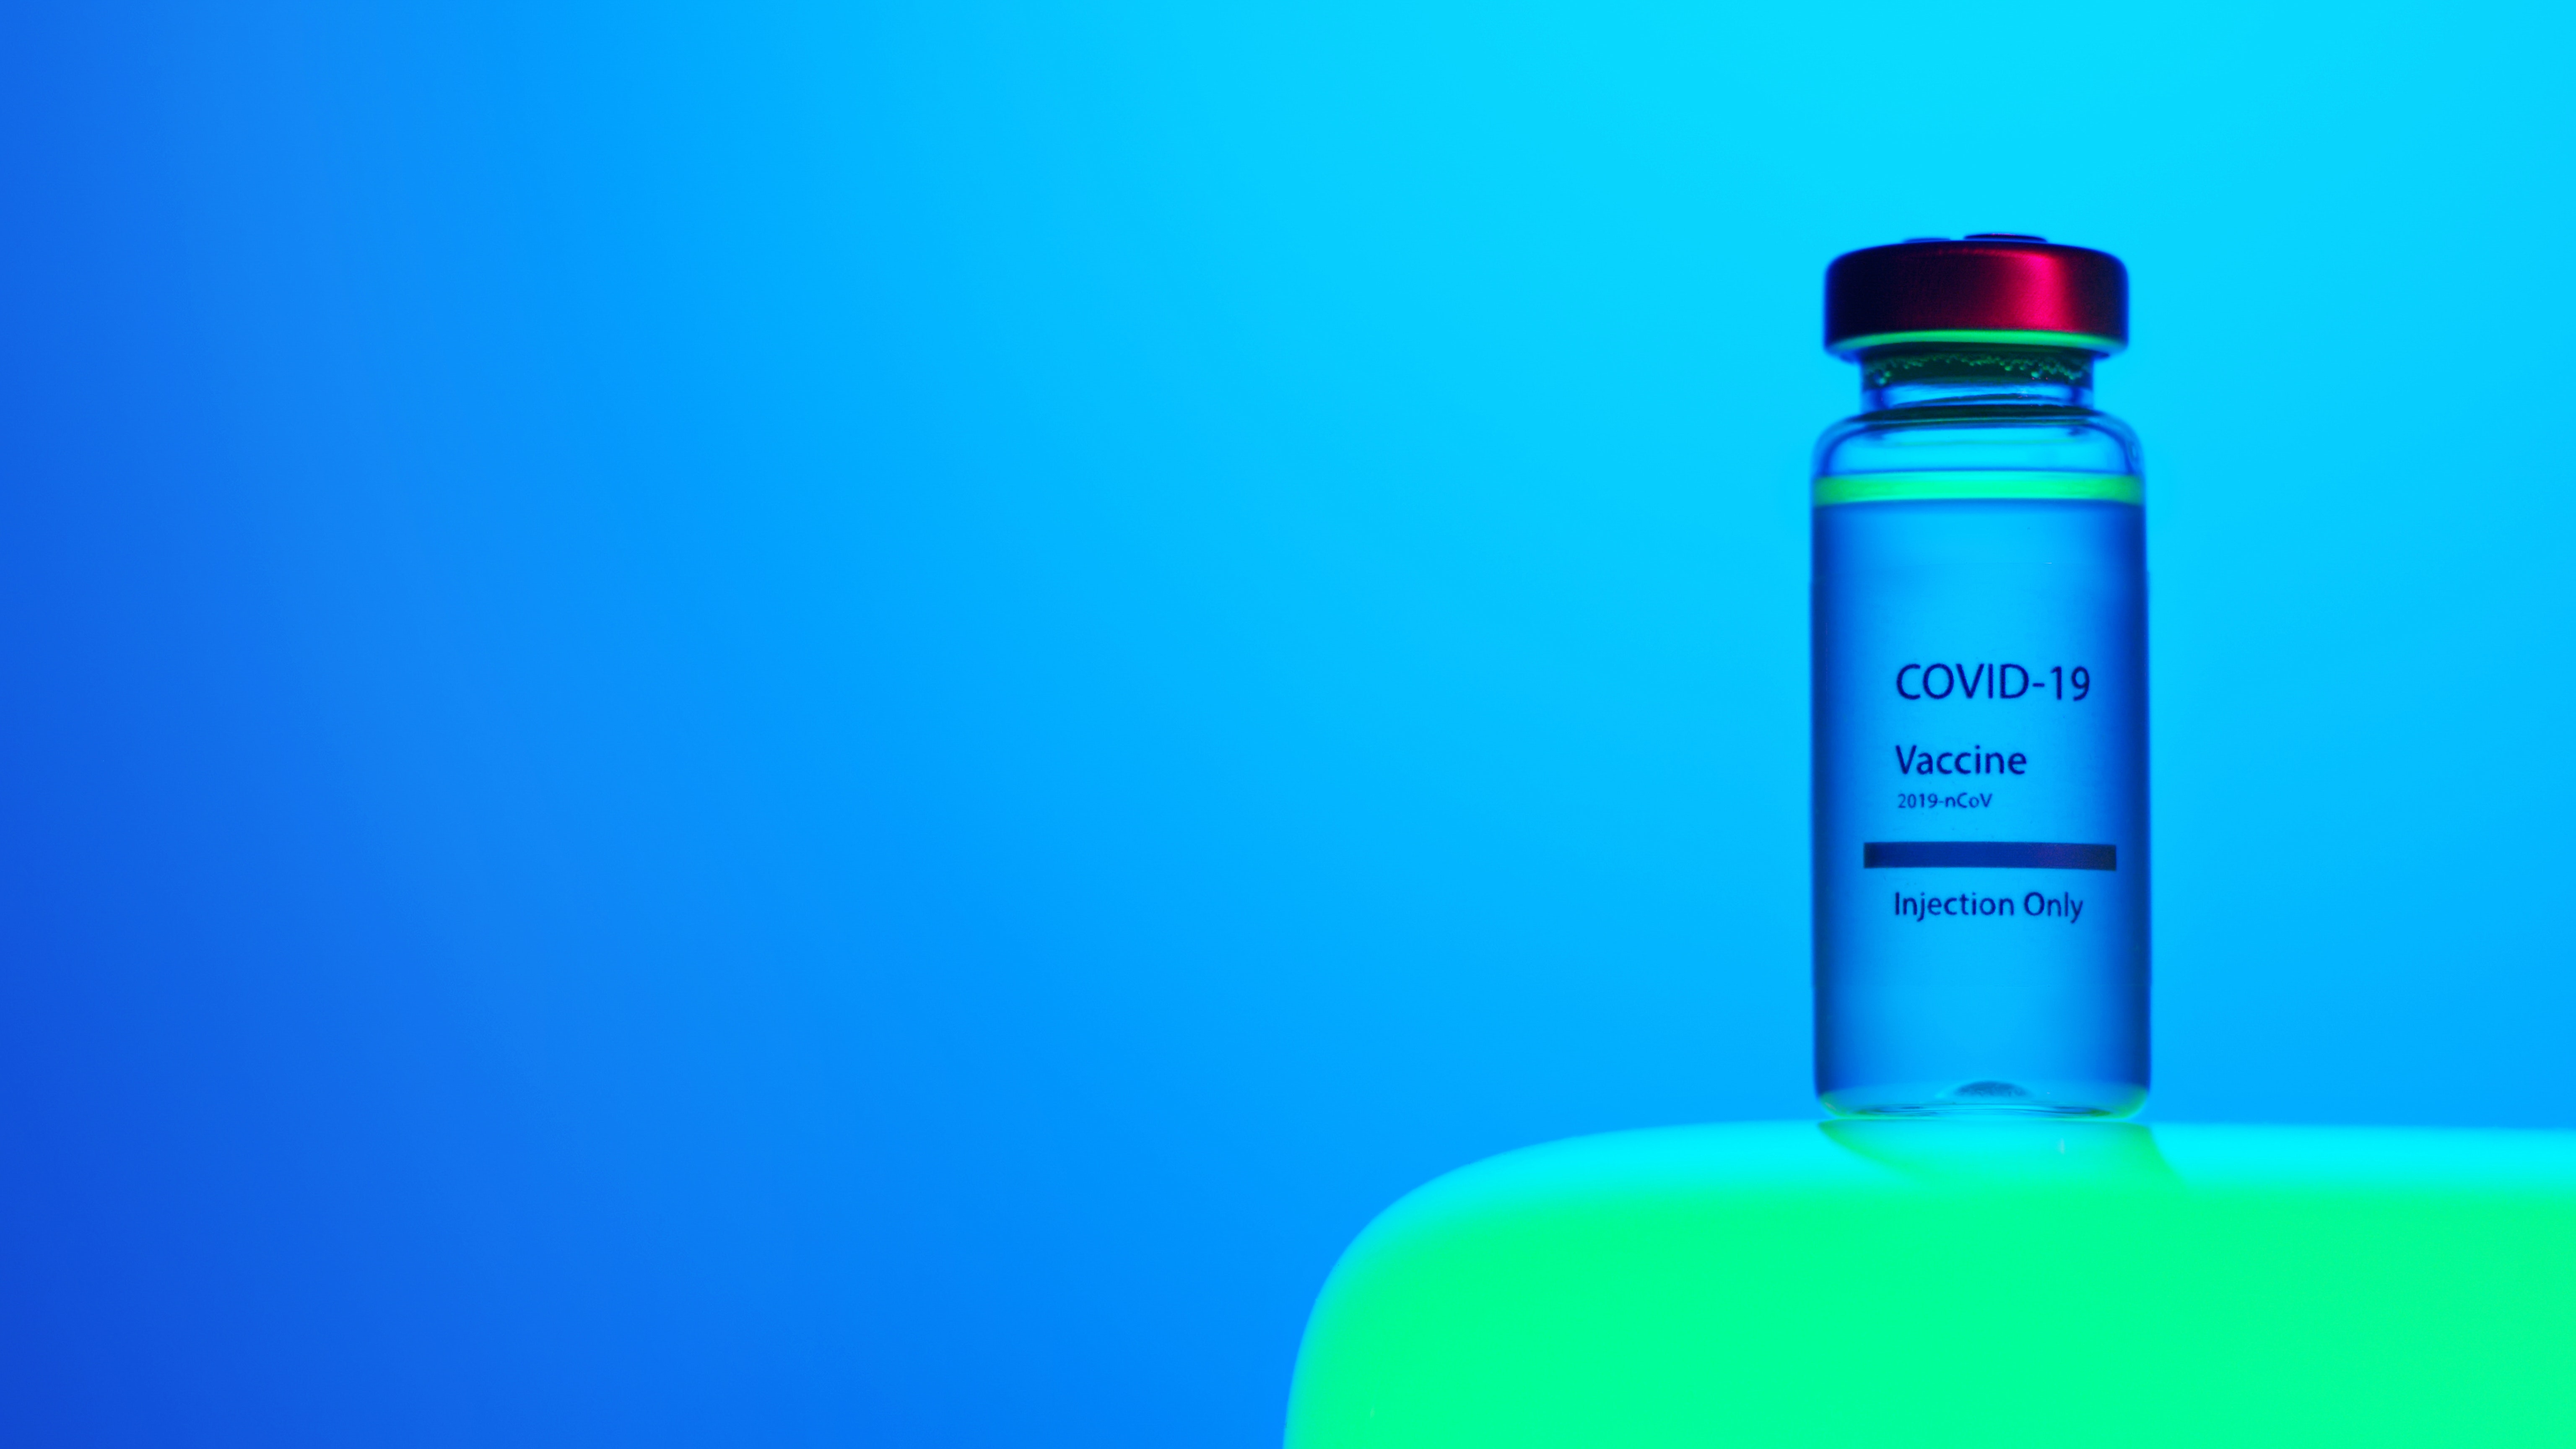

##### Image by [Artem Podrez](https://www.pexels.com/@artempodrez) from [Pexels](https://www.pexels.com/)

## Repository Structure

- The base, starting data can be found in the /data folder and was obtained from the [CDC](https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-Jurisdi/unsk-b7fc)

- Data updates are retrieved from [Reich Labs](https://reichlab.io/) and their [COVID-19 github repository](https://github.com/reichlab/covid19-forecast-hub#ensemble-model).

- All images used throughout the project can be found in the /images folder

- /pickled_data contains all updated dataframes as well as any saved checkpoints used throughout the project such as state-divided data, models, model parameters, and graphs

### Functions
This project largely relies upon the placement of functions within loops. The loops run through each individual state, repeating the function for each one. These functions can be found within the functions.py file.

### Project Overview
An overview of the project can be found at [this slide deck](https://docs.google.com/presentation/d/1z3zzTOvnFKVS_X-35wsUMyr73-Xmh90ihaLCswBJGPs/edit?usp=sharing).

### Contributor
Project by [Isana Mizuma](https://github.com/ismizu)

## Library Imports

In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics

import pickle
import requests

from functions import *

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

# Step 1: Maintaining Data

One of the top items that this project addresses is updateability. The COVID-19 pandemic is an ongoing event. As such, a static prediction made at the time of project completion would soon lose efficacy.

With this in mind, the individual pieces that amalgamate into the final product were all made to run with minimal user input. From data cleaning, to preparing models, to creating each figure; the individual pieces were designed to process each state's outcome through the use of scripts. Thus, when the data is updated, each piece can rapidly be re-run to create the final product.

First, due to limitations of a public API, the vaccination data, obtained from the CDC was downloaded at its existing point.
> General API limits, such as number of calls and amount of data downloadable, are split across all uses of the public API. Thus, the out-of-date csv download was used as a starting point.

In [3]:
pd.read_csv('data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv')

Date  MMWR_week Location  Distributed  Distributed_Janssen  \
0      07/19/2021         29       DC      1077035                54400   
1      07/19/2021         29       MD      8635250               440400   
2      07/19/2021         29       RP        24600                 3800   
3      07/19/2021         29       OK      4074580               222300   
4      07/19/2021         29       WY       521255                34000   
...           ...        ...      ...          ...                  ...   
14133  12/13/2020         51       MP         4875                    0   
14134  12/13/2020         51      LTC            0                    0   
14135  12/13/2020         51       US        13650                    0   
14136  12/13/2020         51       GU         3900                    0   
14137  12/13/2020         51       AS         3900                    0   

       Distributed_Moderna  Distributed_Pfizer  Distributed_Unk_Manuf  \
0                   428320              594315                      0   
1                  3388220             4806630                      0   
2                    20800                   0                      0   
3                  1788700             2063580                      0   
4                   251200              236055                      0   
...                    ...                 ...                    ...   
14133                    0                   0                      0   
14134                    0                   0                      0   
14135                    0                   0                      0   
14136                    0                   0                      0   
14137                    0                   0                      0   

       Dist_Per_100K  Distributed_Per_100k_12Plus  \
0             152609                       176634   
1             142833                       167256   
2             137376                       160868   
3             102972                       122536   
4              90064                       106222   
...              ...                          ...   
14133           8570                            0   
14134              0                            0   
14135              4                            0   
14136           2353                            0   
14137           7003                            0   

       Distributed_Per_100k_18Plus  Distributed_Per_100k_65Plus  Administered  \
0                           186473                      1233110        890364   
1                           183300                       900072       7077471   
2                           176382                       810811         25416   
3                           135605                       641533       3368581   
4                           117129                       525570        438677   
...                            ...                          ...           ...   
14133                            0                            0             0   
14134                            0                            0             0   
14135                            0                            0             0   
14136                            0                            0             0   
14137                            0                            0             0   

       Administered_12Plus  Administered_18Plus  Administered_65Plus  \
0                   890281               866322               172020   
1                  7077098              6624930              1672319   
2                    25416                25416                 3113   
3                  3368389              3237511              1012971   
4                   438654               423946               146733   
...                    ...                  ...                  ...   
14133                    0                    0                    0   
14134                    0                    0  

With the initial, static data, the public API is then relied on for updates. The steps for the function "vax_data_update" are as follows:
1. Retrieve latest data from the CDC
2. Open this project's data
3. Parse the CDC's data and add data not in this project's dataset
4. Save and overwrite the data
5. Return the dataframe
> The project's data is saved as a pickled file, rather than overwriting the csv in the /data folder. Pickled files were used for their lower file size and subsequent faster loading.

In [2]:
vax_data_update()

date location  administered_dose1_pop_pct  series_complete_pop_pct
0     2021-07-28       FL                        57.0                     48.6
1     2021-07-28      IH2                        39.6                     32.6
2     2021-07-28       CO                        59.9                     54.2
3     2021-07-28       PR                        68.6                     59.6
4     2021-07-28       VI                        42.5                     35.5
...          ...      ...                         ...                      ...
14133 2020-12-13       MP                         0.0                      0.0
14134 2020-12-13      LTC                         0.0                      0.0
14135 2020-12-13       US                         0.0                      0.0
14136 2020-12-13       GU                         0.0                      0.0
14137 2020-12-13       AS                         0.0                      0.0

[14723 rows x 4 columns]

This updated dataframe is later assigned to the variable "vax_df_clean" for use in the full data cleaning function.

Below, the following data is retrieved from Reich Lab at UMass-Amherst.
- COVID-19 hospitalizations and fatalities
- Outliers identified by Reich Lab to help the models identify them
> Data is obtained outside of the function as the function is intended to run through a loop and separate data by state. Placing the calls within the function would cause it to re-read the data every time, considerably increasing execution time.

In [2]:
#Retrieve COVID-19 hospitalizations and fatalities
hospitalizations_df = pd.read_csv('https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Hospitalizations.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Deaths.csv')

#Retrieve hospitalization/fatality outliers
hospitalizations_outliers = pd.read_csv('https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-anomalies/outliers-inc-hosps.csv',
                                        index_col = 0)
death_outliers = pd.read_csv('https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-anomalies/outliers-inc-deaths.csv',
                             index_col = 0)

# Remove minor broken dates in hospitalization outliers
broken_dates = hospitalizations_outliers[hospitalizations_outliers['date'] > '2022-01-01'].index
hospitalizations_outliers.drop(index = broken_dates, inplace = True)

#Assign vax data to variable
vax_df_clean = vax_data_update()

With the data updates pulled, the "table_cleaner" function then separates the data per state via the following steps:
1. Separate data per indicated state
2. Rename columns for Facebook Prophet's naming conventions
3. Attach state's vaccination data to the dataframe
4. Reorganize daily data as weekly
5. Save new dataframe as well as state's outliers

In [5]:
#Load a dictionary of state's and their abbreviations
load_states_dict = open('pickled_data/general_data/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

#Run function for each state
for state in list(states.keys()):
    table_cleaner(state,
                  hospitalizations_df,
                  deaths_df,
                  hospitalizations_outliers,
                  death_outliers,
                  vax_df_clean)

One of the more important notes in regards to the data is transforming the data from daily, to weekly. Taking a quick look at the raw data:

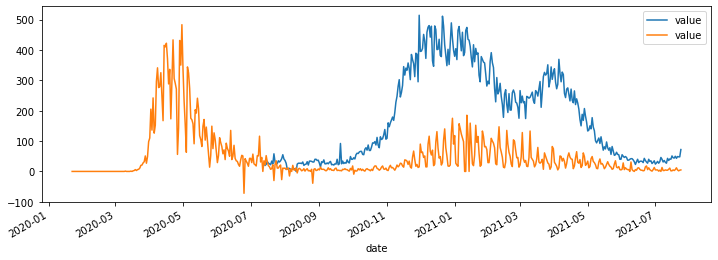

In [3]:
#Prepare test dataframe, change date to datetime dtype
test_hosp = hospitalizations_df[hospitalizations_df['location_name'] == 'New Jersey']
test_hosp['date'] = pd.to_datetime(test_hosp['date'])

test_deaths = deaths_df[deaths_df['location_name'] == 'New Jersey']
test_deaths['date'] = pd.to_datetime(test_deaths['date'])

#Plot data
fig, ax = plt.subplots(figsize = (12, 4))
test_hosp.plot(x = 'date', y = 'value', ax = ax)
test_deaths.plot(x = 'date', y = 'value', ax = ax);

What stands out here is the constant pattern, the daily data is constantly jumping up and down. It seems quite unlikely that covid data patterns just so happen to fall into this pattern. Rather, it appears to be the pattern of weekly updates.

Checking the data below, the spikes are always early in the week, Monday - Wednesday. As a result, I believe that the spikes are due to the release of weekend data.

In [42]:
test_hosp[['date', 'value']].sort_values('date').tail(30)

date  value
15168 2021-06-25     40
11047 2021-06-26     33
15348 2021-06-27     35
8422  2021-06-28     26
17137 2021-06-29     30
19960 2021-06-30     35
10983 2021-07-01     24
9865  2021-07-02     28
12211 2021-07-03     33
15368 2021-07-04     27
10889 2021-07-05     32
18532 2021-07-06     46
20028 2021-07-07     40
17942 2021-07-08     31
18762 2021-07-09     36
8704  2021-07-10     30
15917 2021-07-11     27
8887  2021-07-12     43
15214 2021-07-13     36
16714 2021-07-14     41
15523 2021-07-15     40
18304 2021-07-16     51
17375 2021-07-17     45
19865 2021-07-18     44
13628 2021-07-19     50
12076 2021-07-20     43
16005 2021-07-21     49
15178 2021-07-22     48
16440 2021-07-23     48
20146 2021-07-24     72

To rectify this, the data is reformatted to run on a weekly basis, representing the weekly count of COVID hospitalizations and fatalities.

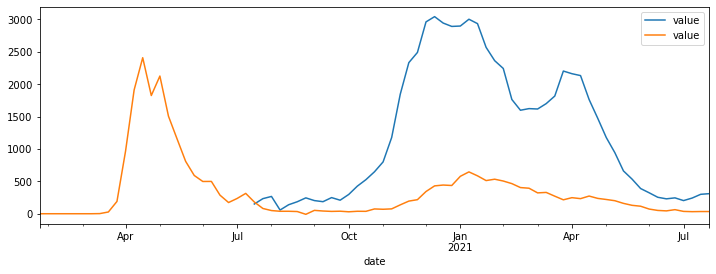

In [4]:
#Alter dataframes to weekly counts
test_hosp_weekly = test_hosp[['date', 'value']].set_index(keys = 'date', drop = True)
test_hosp_weekly = test_hosp_weekly.resample('W').sum()

test_deaths_weekly = test_deaths[['date', 'value']].set_index(keys = 'date', drop = True)
test_deaths_weekly = test_deaths_weekly.resample('W').sum()

#Plot data
fig, ax = plt.subplots(figsize = (12, 4))
test_hosp_weekly.plot(ax = ax)
test_deaths_weekly.plot(ax = ax);

We can now see that the constant jumping data has smoothed out.

With this, the data is now ready to be modeled via fbprophet.

However, before moving on, I did observe an "anomalies" csv within the Reich Lab repository. Utilizing the dates within it, I checked its effect on the final data to see whether additional work on the final dataframes was needed.

Observing a random point, I can see that the "real_diff" column is the alteration from the original observation to what is posted within their final data. As such, I did not utilize the anomalies dataset, as the changes were already reflected in the final dataframe.

In [13]:
#Pull in anomaly data
anomaly_revision_hospitalizations = pd.read_csv('https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-anomalies/revisions-inc-hosp.csv')

#Display hospitalization data at certain point along with anomaly data
display(hospitalizations_df[(hospitalizations_df['location_name'] == 'New Jersey') &
                    (hospitalizations_df['date'] == '2020-11-20')])

anomaly_revision_hospitalizations[(anomaly_revision_hospitalizations['location_name'] == 'New Jersey') &
                                  (anomaly_revision_hospitalizations['date'] == '2020-11-20')]

date location location_name  value
7314  2020-11-20       34    New Jersey    357

location location_name        date  orig_obs  issue_date  real_diff  \
72         34    New Jersey  2020-11-20       362  2020-11-29          1   
2295       34    New Jersey  2020-11-20       363  2020-12-20         -1   
6870       34    New Jersey  2020-11-20       362  2021-03-07         -2   
7320       34    New Jersey  2020-11-20       360  2021-03-14          2   
9630       34    New Jersey  2020-11-20       362  2021-05-02         -5   

      relative_diff  
72         0.002762  
2295      -0.002755  
6870      -0.005525  
7320       0.005556  
9630      -0.013812

# Step 2: Modeling Process

Following the creation of state-dependent dataframes, a function is used to create the models. The steps are as follows:
1. Retrieve state-dependent data
2. Run future vaccination predictions
3. Create models for hospitalization/fatality predictions
4. Save and export the models
>Vaccination numbers are used as exogenous variables to predict hospitalizations and fatalities. As such, their future values are needed in order to make future predictions on hospitalizations and fatalities. Therefore, an additional machine learning model is required to create those predictions.

    > Note: All script cells reload the states dictionary. Scripts load data by default, allowing them to be run independent of each other. As such, the states are reloaded each time to negate dependence on running previous cells.

In [6]:
#Load a dictionary of state's and their abbreviations
load_states_dict = open('pickled_data/general_data/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

#Run function for each state
for state in list(states.keys()):
    make_model(state)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

The first round of model-creation was done with a set of general settings for each model to test the capability of each script. Following the completion of the base scripts, a cross validation script was written to view the efficacy of each model. The script utilizes each model's Mean Absolute Percentage Error (MAPE) score as it is not affected by the scale of the data.
>Note: Initially the data was organized the average daily cases per week, rather than total weekly count. Data was altered for better interpretability, but scores below represent the original organization.

In [193]:
initial_state = pd.DataFrame(columns = ['state',
                                        'dose_one_score',
                                        'series_complete_score',
                                        'fatality_score',
                                        'hosp_score'])

load_states_dict = open('pickled_data/general_data/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

for state in list(states.keys()):
    initial_state = score_check(state, initial_state)

pickle_initial_state = open(f'pickled_data/general_data/initial_state.pickle', 'wb')
pickle.dump(initial_state, pickle_initial_state)
pickle_initial_state.close()

initial_state

INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 6 forecasts wit

INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 25.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts wit

INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 25.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet

INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 25.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater

INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 25.
INFO:prophet:Making 4 forecasts wit

INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 6 forecasts wit

INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 25.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts wit

INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 25.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet

state  dose_one_score  series_complete_score  fatality_score  hosp_score
0     AK            0.01                   0.07            0.78        1.18
1     AL            0.03                   0.10            2.18        0.66
2     AR            0.02                   0.09            1.50        1.99
3     AZ            0.02                   0.05            1.91        1.37
4     CA            0.05                   0.08            1.31        0.86
5     CO            0.05                   0.12            2.44        1.05
6     CT            0.05                   0.09            2.45        0.91
7     DE            0.05                   0.11            3.96        0.80
8     FL            0.04                   0.09            0.71        1.00
9     GA            0.02                   0.14            1.02        0.77
10    HI            0.10                   0.15            5.35        1.45
11    IA            0.04                   0.09            0.60        1.17
12    ID            0.03                   0.08            1.50        0.59
13    IL            0.05                   0.09            1.35        0.52
14    IN            0.04                   0.07            0.99        0.98
15    KS            0.02                   0.06            0.80        0.77
16    KY            0.03                   0.05            1.18        0.49
17    LA            0.01                   0.06            0.68        1.41
18    MA            0.07                   0.11            1.14        1.55
19    MD            0.05                   0.11            1.20        1.00
20    ME            0.06                   0.12            0.53        1.80
21    MI            0.05                   0.10            1.41        1.01
22    MN            0.06                   0.10            2.10        0.54
23    MO            0.03                   0.06            0.90        2.29
24    MS            0.02                   0.06            0.45        0.83
25    MT            0.03                   0.08            1.53        0.87
26    NC            0.05                   0.06            0.51        1.08
27    ND            0.02                   0.06            2.99        0.81
28    NE            0.02                   0.09            9.13        0.76
29    NH            0.03                   0.14            0.97        0.74
30    NJ            0.06                   0.10            1.38        0.82
31    NM            0.02                   0.07            1.00        1.30
32    NV            0.02                   0.09            0.77        0.65
33    NY            0.05                   0.08            2.24        1.48
34    OH            0.04                   0.10            2.27        0.66
35    OK            0.01                   0.03            1.22        0.62
36    OR            0.08                   0.12            0.53        0.51
37    PA            0.06                   0.10            1.22        1.09
38    RI            0.06                   0.08            1.71        1.59
39    SC            0.02                   0.08            1.15        1.29
40    SD            0.01                   0.05            0.96        1.45
41    TN            0.03                   0.05            0.94        1.23
42    TX            0.03                   0.09            0.73        0.61
43    UT            0.03                   0.09            0.59        0.50
44    VA            0.05                   0.11            4.27        0.68
45    VT            0.11                   0.14            3.36        3.93
46    WA            0.06                   0.10            0.81        0.76
47    WI            0.03                   0.08            1.03        0.89
48    WV            0.02                   0.06            2.78        1.19
49    WY            0.01                   0.08            1.03        0.78

In [194]:
initial_state

state  dose_one_score  series_complete_score  fatality_score  hosp_score
0     AK            0.01                   0.07            0.78        1.18
1     AL            0.03                   0.10            2.18        0.66
2     AR            0.02                   0.09            1.50        1.99
3     AZ            0.02                   0.05            1.91        1.37
4     CA            0.05                   0.08            1.31        0.86
5     CO            0.05                   0.12            2.44        1.05
6     CT            0.05                   0.09            2.45        0.91
7     DE            0.05                   0.11            3.96        0.80
8     FL            0.04                   0.09            0.71        1.00
9     GA            0.02                   0.14            1.02        0.77
10    HI            0.10                   0.15            5.35        1.45
11    IA            0.04                   0.09            0.60        1.17
12    ID            0.03                   0.08            1.50        0.59
13    IL            0.05                   0.09            1.35        0.52
14    IN            0.04                   0.07            0.99        0.98
15    KS            0.02                   0.06            0.80        0.77
16    KY            0.03                   0.05            1.18        0.49
17    LA            0.01                   0.06            0.68        1.41
18    MA            0.07                   0.11            1.14        1.55
19    MD            0.05                   0.11            1.20        1.00
20    ME            0.06                   0.12            0.53        1.80
21    MI            0.05                   0.10            1.41        1.01
22    MN            0.06                   0.10            2.10        0.54
23    MO            0.03                   0.06            0.90        2.29
24    MS            0.02                   0.06            0.45        0.83
25    MT            0.03                   0.08            1.53        0.87
26    NC            0.05                   0.06            0.51        1.08
27    ND            0.02                   0.06            2.99        0.81
28    NE            0.02                   0.09            9.13        0.76
29    NH            0.03                   0.14            0.97        0.74
30    NJ            0.06                   0.10            1.38        0.82
31    NM            0.02                   0.07            1.00        1.30
32    NV            0.02                   0.09            0.77        0.65
33    NY            0.05                   0.08            2.24        1.48
34    OH            0.04                   0.10            2.27        0.66
35    OK            0.01                   0.03            1.22        0.62
36    OR            0.08                   0.12            0.53        0.51
37    PA            0.06                   0.10            1.22        1.09
38    RI            0.06                   0.08            1.71        1.59
39    SC            0.02                   0.08            1.15        1.29
40    SD            0.01                   0.05            0.96        1.45
41    TN            0.03                   0.05            0.94        1.23
42    TX            0.03                   0.09            0.73        0.61
43    UT            0.03                   0.09            0.59        0.50
44    VA            0.05                   0.11            4.27        0.68
45    VT            0.11                   0.14            3.36        3.93
46    WA            0.06                   0.10            0.81        0.76
47    WI            0.03                   0.08            1.03        0.89
48    WV            0.02                   0.06            2.78        1.19
49    WY            0.01                   0.08            1.03        0.78

In [42]:
load_initial_state = open('pickled_data/general_data/initial_state.pickle','rb')
initial_state = pickle.load(load_initial_state)
load_initial_state.close()

print(f'''The average MAPE scores are:
    Dose One: {round(initial_state.mean()[0], 2)}
    Series Complete: {round(initial_state.mean()[1], 2)}
    Fatalities: {round(initial_state.mean()[2], 2)}
    Hospitalizations: {round(initial_state.mean()[3], 2)}''')

The average MAPE scores are:
    Dose One: 0.04
    Series Complete: 0.09
    Fatalities: 1.67
    Hospitalizations: 1.07


Viewing these score, I can see that the general settings for the vaccination rate was quite good. However, an important note for this is that the vaccination rate does not drop. The population percent is likely calculated as a rate of vaccinated individuals versus the most recent census' stated population. Unless a large population shift is observed by a census update, the number cannot drop as individuals cannot become unvaccinated. Thus, the incremental climb is easier for machine learning to model.

However, the error for hospitalizations and fatalities is quite high. At the time of running, the scale of the data was quite lower (as noted above). However, a MAPE score of 5.35 (in the case of Hawaii) shows that the general settings have a huge variance in performance.

Seeing this, a gridsearch is run to gather the best parameters for each model. First, the initial vaccination models are gridsearched.

In [293]:
load_states_dict = open('pickled_data/general_data/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

for state in list(states.keys()):
    vax_params(state)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabli

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabli

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints 

INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of o

INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of obs

INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run 

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 f

INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of o

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of obs

INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasona

INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasona

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs betw

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints 

INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.

INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disablin

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changep

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 f

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of ob

INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of o

INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run 

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disablin

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints 

INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of o

INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of obs

INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasona

INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run p

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:Making 4 f

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs betw

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of obs

INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.

INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonal

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

Following this, a gridsearch is run for the hospitalization/fatality data.

In [349]:
load_states_dict = open('pickled_data/general_data/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

for state in list(states.keys()):
    main_params(state)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number 

With these parameters, the function for model creation was then updated to pull the pickled best parameter data for utilization in the models.

After updating, the function was run once again to create the most up-to-date models.

In [6]:
#Load a dictionary of state's and their abbreviations
load_states_dict = open('pickled_data/general_data/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

#Run function for each state
for state in list(states.keys()):
    make_model(state)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

I then re-run the score-check to observe the effects the grid-search had on the models.

In [2]:
updated_state = pd.DataFrame(columns = ['state',
                                        'dose_one_score',
                                        'series_complete_score',
                                        'fatality_score',
                                        'hosp_score'])

load_states_dict = open('pickled_data/general_data/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

for state in list(states.keys()):
    updated_state = score_check(state, updated_state)

pickle_updated_state = open(f'pickled_data/general_data/updated_state.pickle', 'wb')
pickle.dump(updated_state, pickle_updated_state)
pickle_updated_state.close()

INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_ch

INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts wi

INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater

INFO:prophet:n_changepoints greater than number of observations. Using 29.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater

INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:n_changepoints greater than number of observations. Using 26.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n

INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater

INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greate

INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-05-30 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 6 forecasts with cutoffs between 2020-05-03 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Making 4 forecasts with cutoffs between 2021-05-16 00:00:00 and 2021-06-27 00:00:00
INFO:prophet:

state  dose_one_score  series_complete_score  fatality_score  hosp_score
0     AK            0.01                   0.01            0.47        0.91
1     AL            0.03                   0.05            0.48        1.27
2     AR            0.02                   0.04            1.06        0.76
3     AZ            0.02                   0.05            1.93        1.05
4     CA            0.04                   0.08            1.38        1.31
5     CO            0.05                   0.07            2.81        0.87
6     CT            0.05                   0.08            3.26        0.54
7     DE            0.05                   0.05            1.23        2.66
8     FL            0.04                   0.05            0.27        0.84
9     GA            0.02                   0.05            1.56        0.71
10    HI            0.10                   0.08            4.58        1.25
11    IA            0.04                   0.06            0.92        0.75
12    ID            0.03                   0.04            1.23        0.53
13    IL            0.05                   0.05            0.93        0.65
14    IN            0.04                   0.04            0.60        0.91
15    KS            0.02                   0.03            0.95        0.76
16    KY            0.03                   0.03            0.94        0.55
17    LA            0.01                   0.02            0.67        1.29
18    MA            0.07                   0.11            0.56        0.85
19    MD            0.05                   0.08            2.32        0.79
20    ME            0.06                   0.09            1.05        1.02
21    MI            0.05                   0.07            2.77        0.61
22    MN            0.06                   0.07            2.34        0.90
23    MO            0.03                   0.04            0.89        0.48
24    MS            0.02                   0.06            0.54        1.01
25    MT            0.03                   0.04            1.60        0.86
26    NC            0.05                   0.05            0.38        0.67
27    ND            0.02                   0.02            1.48        0.93
28    NE            0.02                   0.04            1.81        1.01
29    NH            0.03                   0.14            1.10        1.42
30    NJ            0.06                   0.08            1.86        0.89
31    NM            0.02                   0.04            1.29        0.63
32    NV            0.02                   0.05            0.97        0.99
33    NY            0.05                   0.06            1.72        1.43
34    OH            0.04                   0.04            0.95        0.69
35    OK            0.01                   0.04            1.03        1.15
36    OR            0.08                   0.09            1.93        0.41
37    PA            0.06                   0.07            3.34        0.95
38    RI            0.06                   0.08            1.69        1.01
39    SC            0.02                   0.03            1.23        0.80
40    SD            0.01                   0.02            1.27        0.90
41    TN            0.03                   0.05            0.32        1.04
42    TX            0.03                   0.05            0.52        0.83
43    UT            0.03                   0.06            0.55        0.38
44    VA            0.05                   0.07            5.17        0.76
45    VT            0.11                   0.12            3.31        2.54
46    WA            0.06                   0.09            0.99        1.08
47    WI            0.03                   0.04            0.75        0.80
48    WV            0.02                   0.02            2.60        0.54
49    WY            0.01                   0.02            1.54        0.38

In [3]:
updated_state

state  dose_one_score  series_complete_score  fatality_score  hosp_score
0     AK            0.01                   0.01            0.47        0.91
1     AL            0.03                   0.05            0.48        1.27
2     AR            0.02                   0.04            1.06        0.76
3     AZ            0.02                   0.05            1.93        1.05
4     CA            0.04                   0.08            1.38        1.31
5     CO            0.05                   0.07            2.81        0.87
6     CT            0.05                   0.08            3.26        0.54
7     DE            0.05                   0.05            1.23        2.66
8     FL            0.04                   0.05            0.27        0.84
9     GA            0.02                   0.05            1.56        0.71
10    HI            0.10                   0.08            4.58        1.25
11    IA            0.04                   0.06            0.92        0.75
12    ID            0.03                   0.04            1.23        0.53
13    IL            0.05                   0.05            0.93        0.65
14    IN            0.04                   0.04            0.60        0.91
15    KS            0.02                   0.03            0.95        0.76
16    KY            0.03                   0.03            0.94        0.55
17    LA            0.01                   0.02            0.67        1.29
18    MA            0.07                   0.11            0.56        0.85
19    MD            0.05                   0.08            2.32        0.79
20    ME            0.06                   0.09            1.05        1.02
21    MI            0.05                   0.07            2.77        0.61
22    MN            0.06                   0.07            2.34        0.90
23    MO            0.03                   0.04            0.89        0.48
24    MS            0.02                   0.06            0.54        1.01
25    MT            0.03                   0.04            1.60        0.86
26    NC            0.05                   0.05            0.38        0.67
27    ND            0.02                   0.02            1.48        0.93
28    NE            0.02                   0.04            1.81        1.01
29    NH            0.03                   0.14            1.10        1.42
30    NJ            0.06                   0.08            1.86        0.89
31    NM            0.02                   0.04            1.29        0.63
32    NV            0.02                   0.05            0.97        0.99
33    NY            0.05                   0.06            1.72        1.43
34    OH            0.04                   0.04            0.95        0.69
35    OK            0.01                   0.04            1.03        1.15
36    OR            0.08                   0.09            1.93        0.41
37    PA            0.06                   0.07            3.34        0.95
38    RI            0.06                   0.08            1.69        1.01
39    SC            0.02                   0.03            1.23        0.80
40    SD            0.01                   0.02            1.27        0.90
41    TN            0.03                   0.05            0.32        1.04
42    TX            0.03                   0.05            0.52        0.83
43    UT            0.03                   0.06            0.55        0.38
44    VA            0.05                   0.07            5.17        0.76
45    VT            0.11                   0.12            3.31        2.54
46    WA            0.06                   0.09            0.99        1.08
47    WI            0.03                   0.04            0.75        0.80
48    WV            0.02                   0.02            2.60        0.54
49    WY            0.01                   0.02            1.54        0.38

In [4]:
load_updated_state = open('pickled_data/general_data/updated_state.pickle','rb')
updated_state = pickle.load(load_updated_state)
load_updated_state.close()

print(f'''The average MAPE scores are:
    Dose One: {round(updated_state.mean()[0], 2)}
    Series Complete: {round(updated_state.mean()[1], 2)}
    Fatalities: {round(updated_state.mean()[2], 2)}
    Hospitalizations: {round(updated_state.mean()[3], 2)}''')

The average MAPE scores are:
    Dose One: 0.04
    Series Complete: 0.06
    Fatalities: 1.5
    Hospitalizations: 0.93


# Step 3: Creating Visuals

In order to create visuals, a function is first made that takes each model and multiplies the results by a multiplier. When the multiplier is 1, it returns the base predictions (it also saves that base forecast for later use).

The multiplier is used within the figure creation function to allow for multiple steps. Thus, it allows the use of a slider to alter COVID hospitalizations and fatalities based on a changing vaccination rate.

The "make_fig" creates the figure for each state before saving it.

Afterwards, the "show_fig" function can be used to view individual state's graphs.

By saving the complete figured as a pickled file, it can be called upon with only the pickle library, a trait deliberately used to ease deployment.

In [41]:
make_fig('NJ')
show_fig('NJ')

The above is an example of the function's output.

With everything ready, the figure creation function is run for all states.

In [10]:
load_states_dict = open('pickled_data/general_data/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

for state in list(states.keys()):
    make_fig(state)

With all visuals complete, I moved to the final phase of the project which is to manually tune each model. Although for the same purpose, I highly doubted the effectiveness of scripting 50 different sets of models. As such, various functions were put in place to address a few problems such as:
- The gridsearch included a parameter that allowed for a .1 changepoint prior scale. In other words, the strength of changepoint detection. .1 is a very low metric and while the score may be higher, it produces an extremely linear graph that, visually, is not indicative of the true trend.


- Changepoint range parameters were all in a very high range. This is how much data to consider when detecting changes in the trend. Unfortunately, a problem this presented was when hospitalizations or fatalities rose, the model incorrectly identified this as a changepoint caused by vaccination rates. As such, hospitalizations and fatalities rose when the vaccination rate rose.

To address these points, a function, "check_," was implemented. This would print all gridsearched parameters in relation to their state. One of the biggest areas addressed via this method was the .1 changepoint prior scale. To reduce the linearity created by the model, nearly all of these values were altered to at least a value of 1.

In [79]:
load_states_dict = open('pickled_data/general_data/states.pickle','rb')
states = pickle.load(load_states_dict)
load_states_dict.close()

for state in list(states.keys()):
    check_(state)

AK Deaths: Rnge: 1 Prior: 1
AK Hosp: Rnge: 0.85 Prior: 5
AL Deaths: Rnge: 1 Prior: 3
AL Hosp: Rnge: 1 Prior: 5
AR Deaths: Rnge: 0.85 Prior: 0.1
AR Hosp: Rnge: 0.85 Prior: 3
AZ Deaths: Rnge: 0.85 Prior: 1
AZ Hosp: Rnge: 0.95 Prior: 0.1
CA Deaths: Rnge: 0.95 Prior: 3
CA Hosp: Rnge: 0.95 Prior: 0.1
CO Deaths: Rnge: 1 Prior: 1
CO Hosp: Rnge: 1 Prior: 5
CT Deaths: Rnge: 0.9 Prior: 3
CT Hosp: Rnge: 0.9 Prior: 5
DE Deaths: Rnge: 0.95 Prior: 1
DE Hosp: Rnge: 0.95 Prior: 3
FL Deaths: Rnge: 1 Prior: 3
FL Hosp: Rnge: 1 Prior: 0.1
GA Deaths: Rnge: 1 Prior: 0.1
GA Hosp: Rnge: 0.85 Prior: 0.1
HI Deaths: Rnge: 1 Prior: 0.1
HI Hosp: Rnge: 1 Prior: 0.5
IA Deaths: Rnge: 0.9 Prior: 1
IA Hosp: Rnge: 0.9 Prior: 3
ID Deaths: Rnge: 0.95 Prior: 3
ID Hosp: Rnge: 0.9 Prior: 1
IL Deaths: Rnge: 1 Prior: 3
IL Hosp: Rnge: 0.95 Prior: 1
IN Deaths: Rnge: 0.95 Prior: 3
IN Hosp: Rnge: 0.95 Prior: 3
KS Deaths: Rnge: 0.95 Prior: 3
KS Hosp: Rnge: 0.95 Prior: 1
KY Deaths: Rnge: 1 Prior: 1
KY Hosp: Rnge: 0.95 Prior: 5
LA De

After addressing clear issues, the function "manual_tune" was created. This allows for manual tuning of existing model parameters. It also overwrites the state's model's parameters so that the new parameters will automatically be utilized by the model creation function.

An example of model tuning can be seen below. The first models can be called upon with the "initial_fig" function. Although the cross validation returned models that had the lowest error at the base level, one of the important features of this project was the altering of vaccination rates to view potential changes in hospitalizations and fatalities. As such, the initial models that did not visualize this proper were altered. Though the margin of error increased, it allowed the creation of visual interpretation.

One of the states that had a particularly bad initial figure (pre-gridsearch), was Nebraska. The "initial_fig" function is called to view its output when default settings were used.

In [13]:
initial_fig('NE')

One of the big points of this graph is that the hospitalizations move in the opposite direction that they should. The intial graph indicates that more vaccinations cause more hospitalizations.

The reason for this is that the "changepoint prior scale" was set to high. It created too many changepoints in the trend and thus, when hospitalizations began rising, it created a changepoint that correlated rising vaccination rates with rising hospitalizations.

Below, the changepoint is altered to account for this trend. Although predictions are less accurate, it allows for proper implementation of the sliding scale.

In [14]:
show_fig('NE')

# Final Statements

Overall, the use of scripts was successful in creating a final product that could be repeated on a per-state level.

The project's first use was for COVID hospitalizations and fatalities predictions one months out. Unfortunately, in order to fulfill the project's second usage, visualizing the effect of vaccination rates, the accuracy of these predictions had to be negatively altered.

However, I viewed the trade-off in a positive light. The first usage, predictions of rates, is still fulfilled. Despite a lowered rate of accuracy, the ability to visualize what might happen, and what could have been, is something I view as more invaluable. Thus, I view the trade-off as a worthy loss.